POST split_time = 2025-11-28 15:07:15.863000
var POST_1 = 0.01179778868270612
var POST_2 = 0.7685539048140334


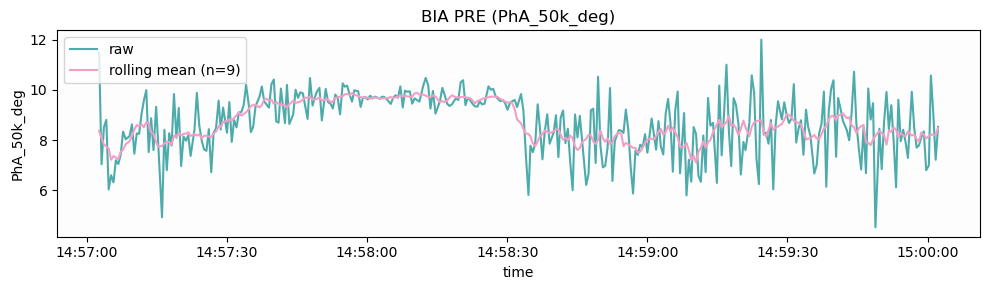

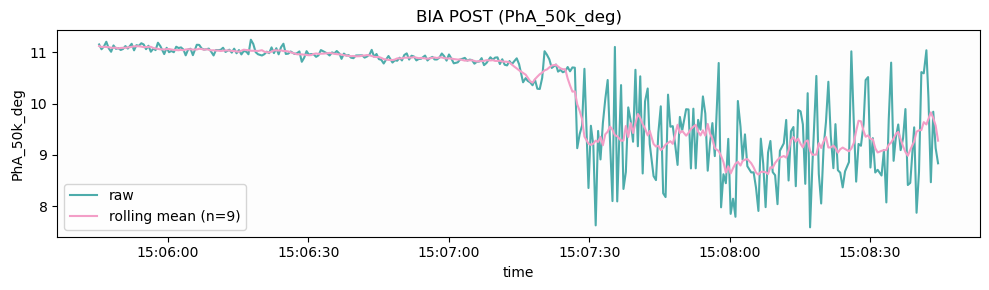

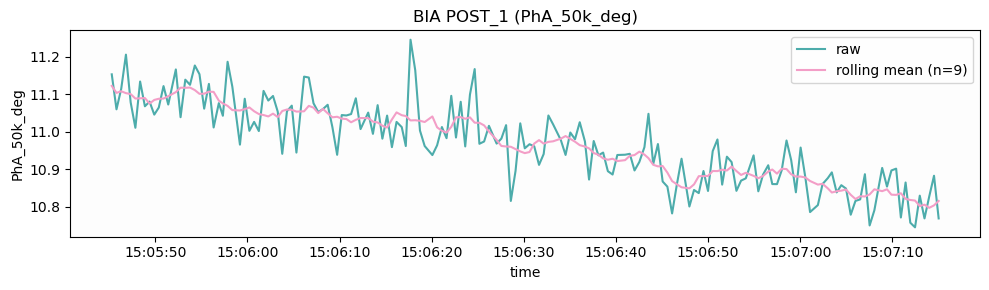

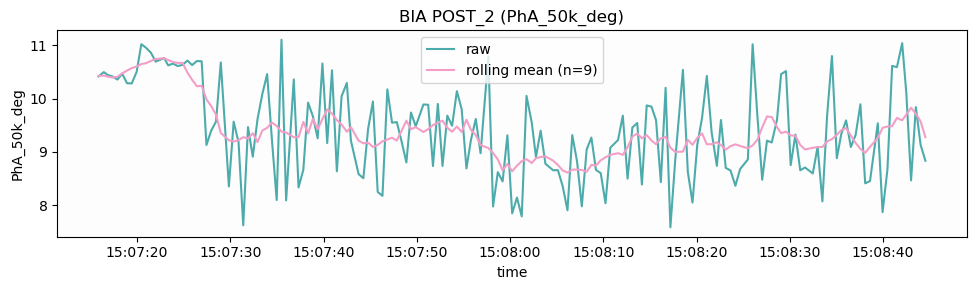


VARIABLES À UTILISER
- bia_pre      : DataFrame PRE
- bia_post     : DataFrame POST (global)
- bia_post_1   : DataFrame POST_1 (avant split)
- bia_post_2   : DataFrame POST_2 (après split)
- pha_pre      : numpy array, PhA_50k_deg sur PRE
- pha_post     : numpy array, PhA_50k_deg sur POST global
- pha_post_1   : numpy array, PhA_50k_deg sur POST_1
- pha_post_2   : numpy array, PhA_50k_deg sur POST_2
- t_pre        : numpy array, temps (s) relatif au début de PRE
- t_post       : numpy array, temps (s) relatif au début de POST (global)
- t_post_1     : numpy array, temps (s) relatif au début de POST_1
- t_post_2     : numpy array, temps (s) relatif au début de POST_2
- fs_pre_est    : float, fs approx PRE (= 1 / dt_médian)
- fs_post_est   : float, fs approx POST global
- fs_post1_est  : float, fs approx POST_1


In [40]:

# BIA RAW IMPORT -> PhA_50k -> PRE/POST WINDOWS -> OUTPUT VARS
# RAW, NO FILTERING / NO RESAMPLING IMPOSED

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, freqz, welch
from numpy.fft import rfft, rfftfreq
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from mpl_toolkits.mplot3d import Axes3D


#==================================================================================
# LOAD DATA, PROCESS BIA, CREATE WINDOWS
#==================================================================================

# CONFIG 

BIA_PKL_PATH = "../data/LEA_BIA_RAW.pkl"   # pkl file exported from BIA device (raw data for pandas)
FREQ_COL = "f_48800"              # ~50 kHz complex impedance column

# Window timestamps (BIA datetime): 3 minutes BEFORE / fatigue inducing protocole / and 3 minutes AFTER
PRE_START_TIME  = "2025-11-28 14:57:02.563"
PRE_END_TIME    = "2025-11-28 15:00:02.563"
POST_START_TIME = "2025-11-28 15:05:45.278"
POST_END_TIME   = "2025-11-28 15:08:44.534"


# LOAD RAW BIA (.pkl)
data_bia_raw = pd.read_pickle(BIA_PKL_PATH)


# ANALYSIS DATAFRAME (same data, cleaner columns)
data_bia = data_bia_raw.copy()

# Parse time
data_bia["time"] = pd.to_datetime(data_bia["timestamp"], errors="coerce")
data_bia = data_bia.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

# Complex impedance at ~50 kHz
data_bia["Z_50k"] = data_bia[FREQ_COL].astype(np.complex128)

# Compute R, Xc, PhA (standard convention: Xc = -imag(Z))
data_bia["R_50k_ohm"]   = np.real(data_bia["Z_50k"])
data_bia["Xc_50k_ohm"]  = -np.imag(data_bia["Z_50k"])
data_bia["PhA_50k_deg"] = np.degrees(np.arctan2(data_bia["Xc_50k_ohm"], data_bia["R_50k_ohm"]))

# Compact analysis view
analysis_cols = ["time", "Z_50k", "R_50k_ohm", "Xc_50k_ohm", "PhA_50k_deg", "sat", "min", "max"]
data_bia_analysis = data_bia[analysis_cols].copy()

# CREATE WINDOWS (PRE / POST)

pre_start  = pd.to_datetime(PRE_START_TIME)
pre_end    = pd.to_datetime(PRE_END_TIME)
post_start = pd.to_datetime(POST_START_TIME)
post_end   = pd.to_datetime(POST_END_TIME)

def slice_window(df, t0, t1):
    m = (df["time"] >= t0) & (df["time"] <= t1)  # inclusive bounds [start, end]
    return df.loc[m].copy()

bia_pre  = slice_window(data_bia_analysis, pre_start, pre_end)
bia_post = slice_window(data_bia_analysis, post_start, post_end)

#==================================================================================
# POST_1 / POST_2 (hard segmentation, variance change-point MLE)
#==================================================================================

# Work on the POST PhA series
s_post = pd.to_numeric(bia_post["PhA_50k_deg"], errors="coerce").to_numpy()
finite_mask = np.isfinite(s_post)
y = s_post[finite_mask]
n = len(y)

K_MIN = int(0.15 * n)  # avoid edges
K_MAX = int(0.85 * n)

# (Gaussian, different variances) MLE split: minimize n1*log(var1)+n2*log(var2)
scores = []
for k in range(K_MIN, K_MAX):
    v1 = np.var(y[:k], ddof=1)
    v2 = np.var(y[k:], ddof=1)
    scores.append(len(y[:k]) * np.log(v1) + len(y[k:]) * np.log(v2))

k_f = int(np.argmin(scores) + K_MIN)              # split index in finite-only y
finite_idx = np.flatnonzero(finite_mask)          # mapping to dataframe rows
k_df = int(finite_idx[k_f])                       # split index in bia_post rows
split_time = bia_post["time"].iloc[k_df]

bia_post_1 = bia_post.iloc[:k_df].copy()
bia_post_2 = bia_post.iloc[k_df:].copy()

print("POST split_time =", split_time)
print("var POST_1 =", float(pd.to_numeric(bia_post_1["PhA_50k_deg"], errors="coerce").var(ddof=1)))
print("var POST_2 =", float(pd.to_numeric(bia_post_2["PhA_50k_deg"], errors="coerce").var(ddof=1)))

#==================================================================================
#  PLOTS (just for verification)
#==================================================================================

def plot_window(df_win, title, y_col="PhA_50k_deg", smooth_n=9):
    if len(df_win) < 5:
        print("Not enough points to plot:", title)
        return
    d = df_win.copy()
    d["time"] = pd.to_datetime(d["time"])
    d = d.sort_values("time")
    y = pd.to_numeric(d[y_col], errors="coerce")
    y_sm = y.rolling(smooth_n, center=True, min_periods=1).mean()

    plt.figure(figsize=(10,3))
    plt.plot(d["time"], y, alpha=0.7, label="raw", color="#028A88")  # teal
    plt.plot(d["time"], y_sm, label=f"rolling mean (n={smooth_n})", color="#F39EC7")  # pink
    plt.title(title, color="#000000")
    plt.xlabel("time", color="#000000")
    plt.ylabel(y_col, color="#000000")
    plt.gca().set_facecolor("#FDFDFD")  # light background
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_window(bia_pre,  "BIA PRE (PhA_50k_deg)")
plot_window(bia_post, "BIA POST (PhA_50k_deg)")
plot_window(bia_post_1, "BIA POST_1 (PhA_50k_deg)")
plot_window(bia_post_2, "BIA POST_2 (PhA_50k_deg)")

# OUTPUT (variables to use)


pha_pre    = bia_pre["PhA_50k_deg"].astype(float).dropna().to_numpy()
pha_post   = bia_post["PhA_50k_deg"].astype(float).dropna().to_numpy()
pha_post_1 = bia_post_1["PhA_50k_deg"].astype(float).dropna().to_numpy()
pha_post_2 = bia_post_2["PhA_50k_deg"].astype(float).dropna().to_numpy()

t_pre  = (bia_pre["time"]  - bia_pre["time"].iloc[0]).dt.total_seconds().to_numpy()
t_post = (bia_post["time"] - bia_post["time"].iloc[0]).dt.total_seconds().to_numpy()
t_post_1 = (bia_post_1["time"] - bia_post_1["time"].iloc[0]).dt.total_seconds().to_numpy()
t_post_2 = (bia_post_2["time"] - bia_post_2["time"].iloc[0]).dt.total_seconds().to_numpy()

dt_pre_med  = float(bia_pre["time"].diff().dt.total_seconds().median())
dt_post_med = float(bia_post["time"].diff().dt.total_seconds().median())
dt_post1_med = float(bia_post_1["time"].diff().dt.total_seconds().median())
dt_post2_med = float(bia_post_2["time"].diff().dt.total_seconds().median())

fs_pre_est   = 1.0 / dt_pre_med
fs_post_est  = 1.0 / dt_post_med
fs_post1_est = 1.0 / dt_post1_med
fs_post2_est = 1.0 / dt_post2_med

print("\nVARIABLES À UTILISER")
print("- bia_pre      : DataFrame PRE")
print("- bia_post     : DataFrame POST (global)")
print("- bia_post_1   : DataFrame POST_1 (avant split)")
print("- bia_post_2   : DataFrame POST_2 (après split)")
print("- pha_pre      : numpy array, PhA_50k_deg sur PRE")
print("- pha_post     : numpy array, PhA_50k_deg sur POST global")
print("- pha_post_1   : numpy array, PhA_50k_deg sur POST_1")
print("- pha_post_2   : numpy array, PhA_50k_deg sur POST_2")
print("- t_pre        : numpy array, temps (s) relatif au début de PRE")
print("- t_post       : numpy array, temps (s) relatif au début de POST (global)")
print("- t_post_1     : numpy array, temps (s) relatif au début de POST_1")
print("- t_post_2     : numpy array, temps (s) relatif au début de POST_2")
print("- fs_pre_est    : float, fs approx PRE (= 1 / dt_médian)")
print("- fs_post_est   : float, fs approx POST global")
print("- fs_post1_est  : float, fs approx POST_1")

In [ ]:
class Stochastic_Process:
    def prep_series(df_win, y_col="PhA_50k_deg", resample_rule="500ms"):
        d = df_win[["time", y_col]].copy()
        d["time"] = pd.to_datetime(d["time"], errors="coerce")
        d = d.dropna(subset=["time"]).sort_values("time").set_index("time")
        y = pd.to_numeric(d[y_col], errors="coerce")
        dt_raw = d.index.to_series().diff().dt.total_seconds().dropna()
        dt_raw_med = float(dt_raw.median()) if len(dt_raw) else np.nan
        if resample_rule is None:
            y_out = y.dropna()
            dt_out = y_out.index.to_series().diff().dt.total_seconds().dropna()
        else:
            y_out = y.resample(resample_rule).mean().interpolate("time")
            dt_out = y_out.index.to_series().diff().dt.total_seconds().dropna()
        info = {
            "start": d.index.min(),
            "end": d.index.max(),
            "n_raw": int(y.notna().sum()),
            "n_out": int(y_out.notna().sum()),
            "dt_raw_med_s": dt_raw_med,
            "dt_out_med_s": float(dt_out.median()) if len(dt_out) else np.nan,
            "resample_rule": resample_rule,
        }
        return y_out, info

    def stationarity_tests(y):
        yv = pd.Series(y).dropna().to_numpy()
        adf_stat, adf_p, _, _, adf_crit, _ = adfuller(yv, autolag="AIC")
        try:
            kpss_stat, kpss_p, _, kpss_crit = kpss(yv, regression="c", nlags="auto")
        except Exception:
            kpss_stat, kpss_p, kpss_crit = np.nan, np.nan, None
        return {
            "adf_stat": float(adf_stat),
            "adf_p": float(adf_p),
            "adf_crit": adf_crit,
            "kpss_stat": float(kpss_stat) if np.isfinite(kpss_stat) else np.nan,
            "kpss_p": float(kpss_p) if np.isfinite(kpss_p) else np.nan,
            "kpss_crit": kpss_crit,
        }

    def print_stationarity(st, name):
        print(f"\n{name} | stationarity tests")
        print(f"ADF : stat={st['adf_stat']:.3f} | p={st['adf_p']:.4f}")
        if np.isfinite(st["kpss_stat"]):
            if st["kpss_p"] <= 0.01:
                print(f"KPSS: stat={st['kpss_stat']:.3f} | p<0.01")
            else:
                print(f"KPSS: stat={st['kpss_stat']:.3f} | p={st['kpss_p']:.4f}")
        else:
            print("KPSS: NA (series too short or nearly constant)")

    def ar_grid_search(y_fit, p_max_cap=20):
        yv = pd.Series(y_fit).dropna()
        n = len(yv)
        p_max = max(1, min(p_max_cap, n // 10))
        best_aic = None
        best_bic = None
        for p in range(1, p_max + 1):
            try:
                m = AutoReg(yv, lags=p, old_names=False).fit()
            except Exception:
                continue
            if (best_aic is None) or (m.aic < best_aic.aic):
                best_aic = m
            if (best_bic is None) or (m.bic < best_bic.bic):
                best_bic = m
        if best_aic is None or best_bic is None:
            raise RuntimeError("AR grid search failed (try smaller p_max_cap).")
        return {
            "p_max_used": p_max,
            "model_aic": best_aic,
            "p_aic": int(best_aic.model._maxlag),
            "model_bic": best_bic,
            "p_bic": int(best_bic.model._maxlag),
        }

    def choose_p_by_whiteness(y_fit, p_max_cap=20, lb_lag=20, alpha=0.05):
        yv = pd.Series(y_fit).dropna()
        n = len(yv)
        p_max = max(1, min(p_max_cap, n // 10))
        rows = []
        models = {}
        for p in range(1, p_max + 1):
            try:
                m = AutoReg(yv, lags=p, old_names=False).fit()
                resid = pd.Series(m.resid).dropna()
                lb = acorr_ljungbox(resid, lags=[lb_lag], return_df=True)
                lb_p = float(lb["lb_pvalue"].iloc[0])
                rows.append((p, float(m.aic), float(m.bic), lb_p))
                models[p] = m
            except Exception:
                continue
        scan = pd.DataFrame(rows, columns=["p", "AIC", "BIC", f"LB_p_lag{lb_lag}"]).sort_values("p")
        ok = scan[scan[f"LB_p_lag{lb_lag}"] > alpha]
        if len(ok):
            p_star = int(ok.iloc[0]["p"])
            return {"p": p_star, "model": models[p_star], "passed": True, "p_max_used": p_max}
        else:
            p_bic = int(scan.loc[scan["BIC"].idxmin(), "p"])
            return {"p": p_bic, "model": models[p_bic], "passed": False, "p_max_used": p_max}

    def residual_diagnostics(model, name, lb_lag=20, plot_lags=40):
        resid = pd.Series(model.resid).dropna()
        acf_vals = acf(resid.to_numpy(), nlags=plot_lags, fft=True)
        lags = np.arange(1, plot_lags + 1)
        plt.figure(figsize=(8, 3))
        markerline, stemlines, baseline = plt.stem(lags, acf_vals[1:], basefmt=" ", linefmt="#028A88", markerfmt="o")
        plt.setp(markerline, markerfacecolor="#028A88", markeredgecolor="#028A88")
        plt.setp(stemlines, color="#028A88")
        plt.axhline(0, color="#028A88", linewidth=0.8)
        ci = 1.96 / np.sqrt(len(resid))
        plt.axhspan(-ci, ci, alpha=0.2, color="#F39EC7")
        plt.title(f"{name} | Residual ACF (lags 1–{plot_lags})", color="#000000")
        plt.xlabel("lag", color="#000000")
        plt.gca().set_facecolor("#FFFFFF")
        plt.tight_layout()
        plt.show()
        lb = acorr_ljungbox(resid, lags=[lb_lag], return_df=True)
        lb_p = float(lb["lb_pvalue"].iloc[0])
        return {
            "lb_p": lb_p,
            "resid_var": float(np.var(resid, ddof=1)),
        }

    def run_ar_block(y_fit, name, diff_used):
        print(f"\n {name} | AR modeling")
        print(f"Series used: diff1={diff_used} | n={len(y_fit)}")
        grid = Stochastic_Process.ar_grid_search(y_fit)
        print(f"AR grid search: p_max_used={grid['p_max_used']}")
        print(f"Best by AIC: p={grid['p_aic']} | AIC={grid['model_aic'].aic:.3f} | BIC={grid['model_aic'].bic:.3f}")
        print(f"Best by BIC: p={grid['p_bic']} | AIC={grid['model_bic'].aic:.3f} | BIC={grid['model_bic'].bic:.3f}")
        chosen = Stochastic_Process.choose_p_by_whiteness(y_fit)
        final_p = chosen["p"]
        final_model = chosen["model"]
        if chosen["passed"]:
            print(f"Final AR(p) chosen by whiteness: p={final_p}")
        else:
            print(f"Final AR(p): no p<=p_max achieved Ljung-Box p>0.05 at lag=20.")
            print(f"Using best-BIC fallback: p={final_p}")
            print("Note: remaining autocorrelation suggests ARMA may be more appropriate.")
        print("Params (head):")
        print(final_model.params.head(6))
        diag = Stochastic_Process.residual_diagnostics(final_model, name)
        print(f"Ljung-Box (lag=20): p={diag['lb_p']:.4f}")
        return {
            "name": name,
            "diff1": diff_used,
            "p_aic": grid["p_aic"],
            "p_bic": grid["p_bic"],
            "p_final": int(final_p),
            "aic_final": float(final_model.aic),
            "bic_final": float(final_model.bic),
            "lb_p": diag["lb_p"],
            "resid_var": diag["resid_var"],
        }

In [99]:
#==============================================================
#SPECTRAL ANALYSE
#==============================================================

class SpectralAnalysis:
    def butter_lowpass_filter(data, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    def plot_power_spectrum(freqs, power, title):
        plt.figure(figsize=(10, 4))
        plt.semilogy(freqs, power)
        plt.title(title)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def compute_fft_power_spectrum(signal, fs, window='hann'):
        n = len(signal)
        if window == 'hann':
            win = np.hanning(n)
        elif window == 'hamming':
            win = np.hamming(n)
        else:
            win = np.ones(n)
        signal_windowed = signal * win
        fft_vals = rfft(signal_windowed)
        freqs = rfftfreq(n, d=1.0/fs)
        power = (np.abs(fft_vals) ** 2) / (np.sum(win**2) / n)
        return freqs, power

    def plot_compare_power_spectra(list_freqs, list_power, labels, title, xlabel="Frequency (Hz)", ylabel="Power", logy=True):
        plt.figure(figsize=(14, 5))
        colors = ["#028A88", "#F39EC7", "#d62728", "#1f77b4", "#FFA500"]
        for idx, (freqs, power, label) in enumerate(zip(list_freqs, list_power, labels)):
            color = colors[idx % len(colors)]
            if logy:
                plt.semilogy(freqs, power, label=label, color=color)
            else:
                plt.plot(freqs, power, label=label, color=color)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_raw_and_filtered_panels(
        data_list,
        titles=None,
        xlabels=None,
        ylabels=None,
        suptitle=None,
        figsize=(16, 5)
    ):
        n = len(data_list)
        fig, axes = plt.subplots(1, n, figsize=figsize, squeeze=False)
        if suptitle:
            fig.suptitle(suptitle, fontsize=16, fontweight='bold')
        for i, data in enumerate(data_list):
            ax = axes[0, i]
            ax.plot(data['time'], data['raw'], alpha=0.5, linewidth=0.5, label='Raw', color="#028A88")
            ax.plot(data['time'], data['filtered'], linewidth=2, label='Filtered', color="#F39EC7")
            if titles and i < len(titles):
                ax.set_title(titles[i])
            if xlabels and i < len(xlabels):
                ax.set_xlabel(xlabels[i])
            else:
                ax.set_xlabel('Time (s)')
            if ylabels and i < len(ylabels):
                ax.set_ylabel(ylabels[i])
            else:
                ax.set_ylabel('Phase Angle (°)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_welch_panels(
        list_freqs,
        list_psd,
        titles=None,
        xlabels=None,
        ylabels=None,
        suptitle=None,
        figsize=(14, 4)
    ):
        n = len(list_freqs)
        colors = ["#028A88", "#F39EC7", "#d62728", "#1f77b4", "#FFA500"]
        fig, axes = plt.subplots(1, n, figsize=figsize, squeeze=False)
        if suptitle:
            fig.suptitle(suptitle, fontsize=16, fontweight='bold')
        for i in range(n):
            color = colors[i % len(colors)]
            ax = axes[0, i]
            ax.semilogy(list_freqs[i], list_psd[i], color=color)
            if titles and i < len(titles):
                ax.set_title(titles[i])
            if xlabels and i < len(xlabels):
                ax.set_xlabel(xlabels[i])
            else:
                ax.set_xlabel('Frequency (Hz)')
            if ylabels and i < len(ylabels):
                ax.set_ylabel(ylabels[i])
            else:
                ax.set_ylabel('PSD')
            ax.grid(True)
        plt.tight_layout()
        plt.show()

In [101]:
class fractal_analysis:
    def fractal_dimension_boxcount(signal, time_vector=None):
        signal_norm = (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-10)
        if time_vector is None:
            time_vector = np.arange(len(signal))
        time_norm = (time_vector - np.min(time_vector)) / (np.max(time_vector) - np.min(time_vector) + 1e-10)
        n_points = len(signal)
        min_boxes = 4
        max_boxes = min(n_points // 2, 1000)
        n_divisions = np.logspace(np.log10(min_boxes), np.log10(max_boxes), num=20, dtype=int)
        n_divisions = np.unique(n_divisions)
        box_counts = []
        box_sizes = []
        for n_div in n_divisions:
            box_size = 1.0 / n_div
            box_sizes.append(box_size)
            box_indices_x = (time_norm / box_size).astype(int)
            box_indices_y = (signal_norm / box_size).astype(int)
            box_indices_x = np.clip(box_indices_x, 0, n_div - 1)
            box_indices_y = np.clip(box_indices_y, 0, n_div - 1)
            occupied_boxes = set(zip(box_indices_x, box_indices_y))
            box_counts.append(len(occupied_boxes))
        box_sizes = np.array(box_sizes)
        box_counts = np.array(box_counts)
        log_box_sizes = np.log(box_sizes)
        log_counts = np.log(box_counts)
        coeffs = np.polyfit(log_box_sizes, log_counts, 1)
        D = -coeffs[0]
        return D, box_sizes, box_counts

    def dfa_analysis(signal, min_scale=4, max_scale=None, num_scales=20):
        N = len(signal)
        if max_scale is None:
            max_scale = N // 4
        signal_mean = np.mean(signal)
        y = np.cumsum(signal - signal_mean)
        scales = np.unique(np.logspace(np.log10(min_scale), np.log10(max_scale), num=num_scales, dtype=int))
        fluctuations = []
        for scale in scales:
            num_segments = N // scale
            if num_segments < 1:
                continue
            y_trimmed = y[:num_segments * scale]
            segments = y_trimmed.reshape((num_segments, scale))
            fluctuation_sum = 0
            for segment in segments:
                x_seg = np.arange(scale)
                coeffs = np.polyfit(x_seg, segment, 1)
                trend = np.polyval(coeffs, x_seg)
                residuals = segment - trend
                fluctuation_sum += np.sum(residuals ** 2)
            F_n = np.sqrt(fluctuation_sum / (num_segments * scale))
            fluctuations.append(F_n)
        scales = np.array(scales[:len(fluctuations)])
        fluctuations = np.array(fluctuations)
        log_scales = np.log10(scales)
        log_fluctuations = np.log10(fluctuations)
        coeffs = np.polyfit(log_scales, log_fluctuations, 1)
        alpha = coeffs[0]
        return alpha, scales, fluctuations

    def plot_box_counting_panel(signal_list, labels=None):
        n = len(signal_list)
        fig, axes = plt.subplots(1, n, figsize=(7*n, 5), squeeze=False)
        for i, signal in enumerate(signal_list):
            D, box_sizes, box_counts = fractal_analysis.fractal_dimension_boxcount(signal)
            log_box_sizes = np.log(box_sizes)
            log_counts = np.log(box_counts)
            coeffs = np.polyfit(log_box_sizes, log_counts, 1)
            ax = axes[0, i]
            ax.scatter(log_box_sizes, log_counts, color="#028A88", label='Data points')
            ax.plot(log_box_sizes, np.polyval(coeffs, log_box_sizes), color="#F39EC7", lw=2, label=f'D={D:.3f}')
            title = labels[i] if labels else f"Signal {i+1}"
            ax.set_title(f'{title} — Box Counting')
            ax.set_xlabel('log(Box Size)')
            ax.set_ylabel('log(Count)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_dfa_panel(signal_list, labels=None, min_scale=4, max_scale=100):
        n = len(signal_list)
        fig, axes = plt.subplots(1, n, figsize=(7*n, 5), squeeze=False)
        for i, signal in enumerate(signal_list):
            alpha, scales, fluctuations = fractal_analysis.dfa_analysis(signal, min_scale=min_scale, max_scale=max_scale)
            log_scales = np.log10(scales)
            log_fluctuations = np.log10(fluctuations)
            coeffs = np.polyfit(log_scales, log_fluctuations, 1)
            ax = axes[0, i]
            ax.scatter(log_scales, log_fluctuations, color="#028A88", label='Data points')
            ax.plot(log_scales, np.polyval(coeffs, log_scales), color="#F39EC7", lw=2, label=f'α={alpha:.3f}')
            title = labels[i] if labels else f"Signal {i+1}"
            ax.set_title(f'{title} — DFA')
            ax.set_xlabel('log(Window Size)')
            ax.set_ylabel('log(Fluctuation)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [108]:
class NonLinearAnalysis:
    def _mutual_information(x, y, bins=32):
        H, _, _ = np.histogram2d(x, y, bins=bins)
        s = H.sum()
        if s == 0:
            return 0.0
        pxy = H / s
        px = pxy.sum(axis=1)
        py = pxy.sum(axis=0)
        ix, jy = np.nonzero(pxy)
        mi = np.sum(pxy[ix, jy] * np.log(pxy[ix, jy] / (px[ix] * py[jy])))
        return float(mi)

    def compute_mi_lags(x, max_lag=80, bins=32):
        x = np.asarray(x, dtype=float)
        x = x[np.isfinite(x)]
        if len(x) < 10:
            return np.array([]), np.array([])
        max_lag = min(max_lag, max(1, len(x)//2 - 1))
        lags = np.arange(1, max_lag+1)
        mis = [NonLinearAnalysis._mutual_information(x[:-lag], x[lag:], bins=bins) for lag in lags]
        return lags, np.array(mis)

    def first_local_minimum(lags, vals):
        for i in range(1, len(vals)-1):
            if vals[i] < vals[i-1] and vals[i] < vals[i+1]:
                return int(lags[i])
        return None

    def false_nearest_neighbors(signal, max_dim=10, tau=1, r_thresh=15.0, atol=2.0):
        signal = np.asarray(signal)
        N = len(signal)
        fnn_percentages = []
        for m in range(1, max_dim + 1):
            if N - (m + 1) * tau <= 1:
                break
            Xm = np.array([signal[i:i + m * tau:tau] for i in range(N - m * tau)])
            Xm1 = np.array([signal[i:i + (m + 1) * tau:tau] for i in range(N - (m + 1) * tau)])
            min_len = min(len(Xm), len(Xm1))
            Xm = Xm[:min_len]
            Xm1 = Xm1[:min_len]
            dist_m = np.linalg.norm(Xm[:, None] - Xm[None, :], axis=2)
            np.fill_diagonal(dist_m, np.inf)
            nn_index = np.argmin(dist_m, axis=1)
            nn_dist = np.min(dist_m, axis=1)
            dist_m1 = np.linalg.norm(Xm1 - Xm1[nn_index], axis=1)
            R = np.abs(dist_m1 - nn_dist) / nn_dist
            false_neighbors = np.where((R > r_thresh) | (np.abs(dist_m1) > atol))[0]
            fnn_percent = 100 * len(false_neighbors) / len(Xm1)
            fnn_percentages.append(fnn_percent)
        return fnn_percentages

    def detrend_polynomial(signal, order=3):
        x = np.arange(len(signal))
        coeffs = np.polyfit(x, signal, order)
        trend = np.polyval(coeffs, x)
        detrended = signal - trend
        return detrended

    def sample_entropy(signal, m, r):
        N = len(signal)
        signal = np.asarray(signal, dtype=float)
        def _embed(signal, m):
            return np.array([signal[i:i+m] for i in range(N - m + 1)])
        Xm = _embed(signal, m)
        Xm1 = _embed(signal, m + 1)
        def _count_matches(X, r):
            count = 0
            for i in range(len(X)):
                dist = np.max(np.abs(X - X[i]), axis=1)
                count += np.sum(dist < r) - 1
            return count
        B = _count_matches(Xm, r)
        A = _count_matches(Xm1, r)
        if B <= 0 or A <= 0:
            return np.nan
        ratio = A / B
        ratio = max(min(ratio, 1.0), 1e-10)
        SampEn = -np.log(ratio)
        return max(SampEn, 0.0)

    def phase_randomized_surrogate(x, random_state=None):
        rng = np.random.default_rng(random_state)
        x = np.asarray(x, dtype=float)
        x = x[np.isfinite(x)]
        n = len(x)
        X = np.fft.rfft(x)
        amp = np.abs(X)
        phase = np.angle(X)
        rand_phase = rng.uniform(0, 2*np.pi, size=len(X))
        rand_phase[0] = phase[0]
        if n % 2 == 0:
            rand_phase[-1] = phase[-1]
        X_surr = amp * np.exp(1j * rand_phase)
        x_surr = np.fft.irfft(X_surr, n=n)
        return x_surr

    def check_psd(original, surrogate, nperseg=256):
        nper = min(nperseg, len(original))
        f0, p0 = signal.welch(original, nperseg=nper)
        f1, p1 = signal.welch(surrogate, nperseg=nper)
        plt.figure(figsize=(10, 3))
        plt.semilogy(f0, p0, label="Original", color="#028A88")
        plt.semilogy(f1, p1, "--", label="FT surrogate", color="#F39EC7")
        plt.title("PSD preservation check (Welch)")
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def test_fft_amplitude_preservation(x, x_surr, rtol=1e-10, atol=1e-12):
        x = np.asarray(x, float)
        x_surr = np.asarray(x_surr, float)
        X = np.fft.rfft(x)
        S = np.fft.rfft(x_surr)
        amp_X = np.abs(X)
        amp_S = np.abs(S)
        rel_rmse = np.sqrt(np.mean(((amp_S - amp_X) / (amp_X + 1e-12))**2))
        max_rel = np.max(np.abs(amp_S - amp_X) / (amp_X + 1e-12))
        ok = np.allclose(amp_S, amp_X, rtol=rtol, atol=atol)
        print("FFT amplitude preservation test")
        print(f"  allclose: {ok}")
        print(f"  rel_RMSE: {rel_rmse:.3e}")
        print(f"  max_rel : {max_rel:.3e}")
        return ok, rel_rmse, max_rel

    def plot_mi(lags, mis, chosen_tau=None, dt=None, title="Mutual information vs lag"):
        plt.figure(figsize=(8, 3))
        plt.plot(lags, mis, '-o', color="#028A88")
        if chosen_tau is not None:
            plt.axvline(chosen_tau, color="#F39EC7", linestyle='--', label=f'chosen τ={chosen_tau} samp')
            if dt is not None:
                plt.axvline(chosen_tau*dt, color="#F39EC7", linestyle=':', label=f'(~{chosen_tau*dt:.3f}s)')
        plt.xlabel('lag (samples)')
        plt.ylabel('Mutual information (nats)')
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_fnn(fnn_pre, fnn_post, label_pre="PRE", label_post="POST"):
        plt.figure(figsize=(8, 3))
        plt.plot(range(1, len(fnn_pre)+1), fnn_pre, '-o', label=label_pre, color="#028A88")
        plt.plot(range(1, len(fnn_post)+1), fnn_post, '-o', label=label_post, color="#F39EC7")
        plt.xlabel('Embedding dimension')
        plt.ylabel('FNN (%)')
        plt.title('False Nearest Neighbors')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_fnn_multi(fnn_list, labels=None, colors=None, title="False Nearest Neighbors"):
        n = len(fnn_list)
        if colors is None:
            colors = ["#028A88", "#F39EC7", "#d62728", "#1f77b4", "#FFA500"]
        if labels is None:
            labels = [f"Signal {i+1}" for i in range(n)]
        plt.figure(figsize=(8, 4))
        for i in range(n):
            plt.plot(range(1, len(fnn_list[i]) + 1), fnn_list[i], '-o', label=labels[i], color=colors[i % len(colors)])
        plt.xlabel('Embedding dimension')
        plt.ylabel('FNN (%)')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_phase_space_2d_3d(x, tau, d=3, label="Signal"):
        if x is None or len(x) < 10 or d < 3:
            print(f"{label}: signal trop court ou d < 3")
            return
        emb = np.array([x[i:i + d * tau:tau] for i in range(len(x) - (d - 1) * tau)])
        fig = plt.figure(figsize=(12, 5))
        # 2D
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(emb[:, 0], emb[:, 1], color="#028A88", lw=0.8, alpha=0.8)
        ax1.set_xlabel('x(t)')
        ax1.set_ylabel(f'x(t+{tau})')
        ax1.set_title(f'{label} — Phase Space 2D (d=2, τ={tau})')
        # 3D
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(emb[:, 0], emb[:, 1], emb[:, 2], color="#028A88", lw=0.8, alpha=0.8)
        ax2.set_xlabel('x(t)')
        ax2.set_ylabel(f'x(t+{tau})')
        ax2.set_zlabel(f'x(t+2{tau})')
        ax2.set_title(f'{label} — Phase Space 3D (d=3, τ={tau})')
        plt.tight_layout()
        plt.show()

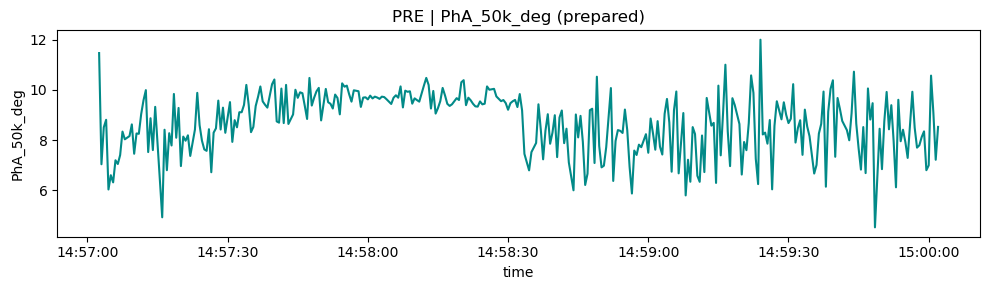

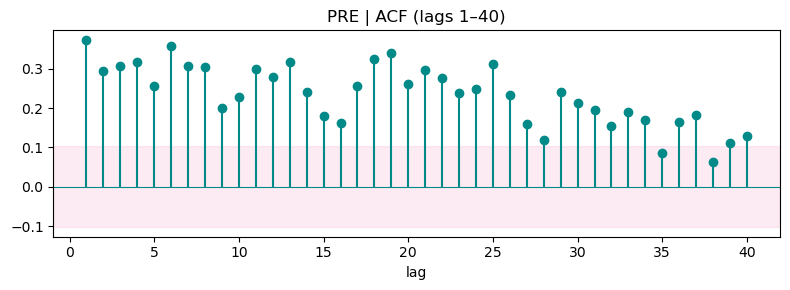

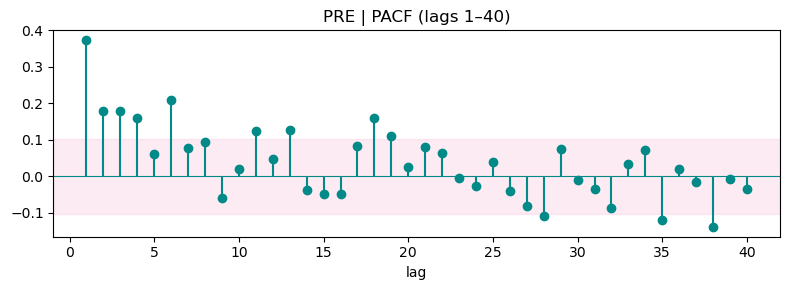

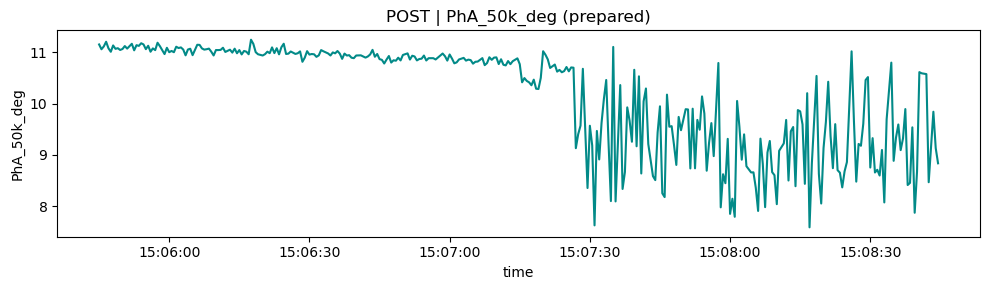

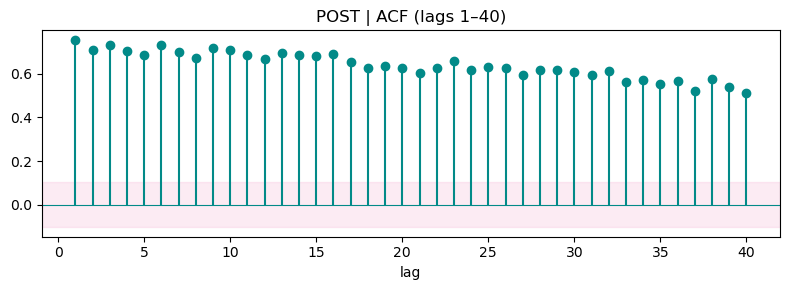

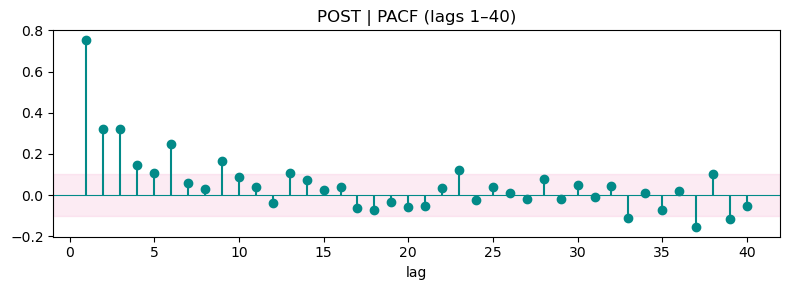

C:\Users\lucas\AppData\Local\Temp\ipykernel_21580\3757262860.py:134: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(yv, regression="c", nlags="auto")
C:\Users\lucas\AppData\Local\Temp\ipykernel_21580\3757262860.py:134: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(yv, regression="c", nlags="auto")



PRE | stationarity tests
ADF : stat=-1.860 | p=0.3513
KPSS: stat=0.743 | p<0.01

POST | stationarity tests
ADF : stat=-0.968 | p=0.7647
KPSS: stat=2.675 | p<0.01


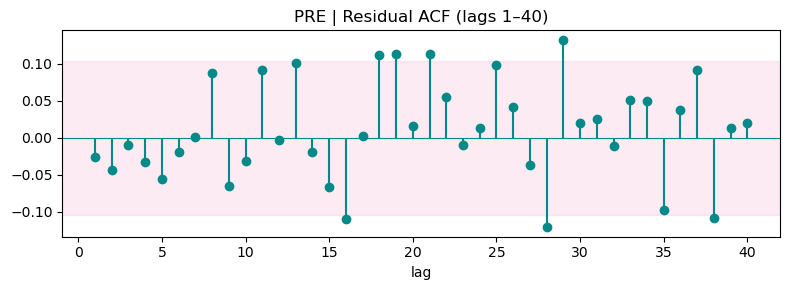

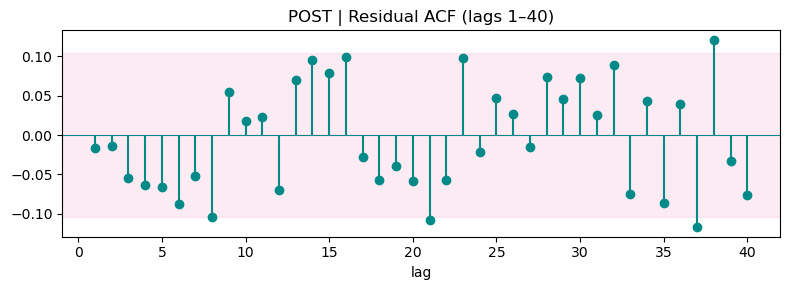

In [98]:
# =============================================================================
# 1. STOCHASTIC PROCESS ANALYSIS
# =============================================================================

# ACF and PACF
y_pre, info_pre = Stochastic_Process.prep_series(bia_pre)
Stochastic_Process.plot_series_acf_pacf(y_pre, "PRE")
y_post, info_post = Stochastic_Process.prep_series(bia_post)
Stochastic_Process.plot_series_acf_pacf(y_post, "POST")

# Stationarity tests
st_pre = Stochastic_Process.stationarity_tests(y_pre)
Stochastic_Process.print_stationarity(st_pre, "PRE")
st_post = Stochastic_Process.stationarity_tests(y_post)
Stochastic_Process.print_stationarity(st_post, "POST")

# AR modeling
grid_pre = Stochastic_Process.ar_grid_search(y_pre)
grid_post = Stochastic_Process.ar_grid_search(y_post)

# Choose final p by whiteness
chosen_pre = Stochastic_Process.choose_p_by_whiteness(y_pre)
chosen_post = Stochastic_Process.choose_p_by_whiteness(y_post)

# Residual diagnostics
diag_pre = Stochastic_Process.residual_diagnostics(chosen_pre['model'], "PRE")
diag_post = Stochastic_Process.residual_diagnostics(chosen_post['model'], "POST")


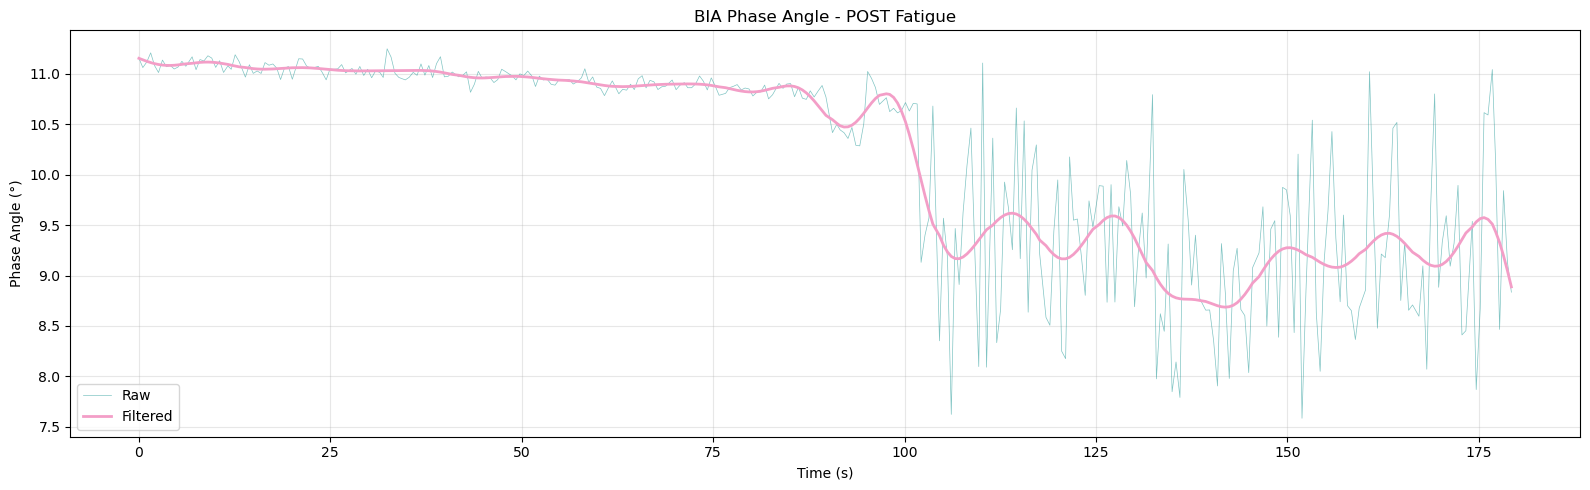

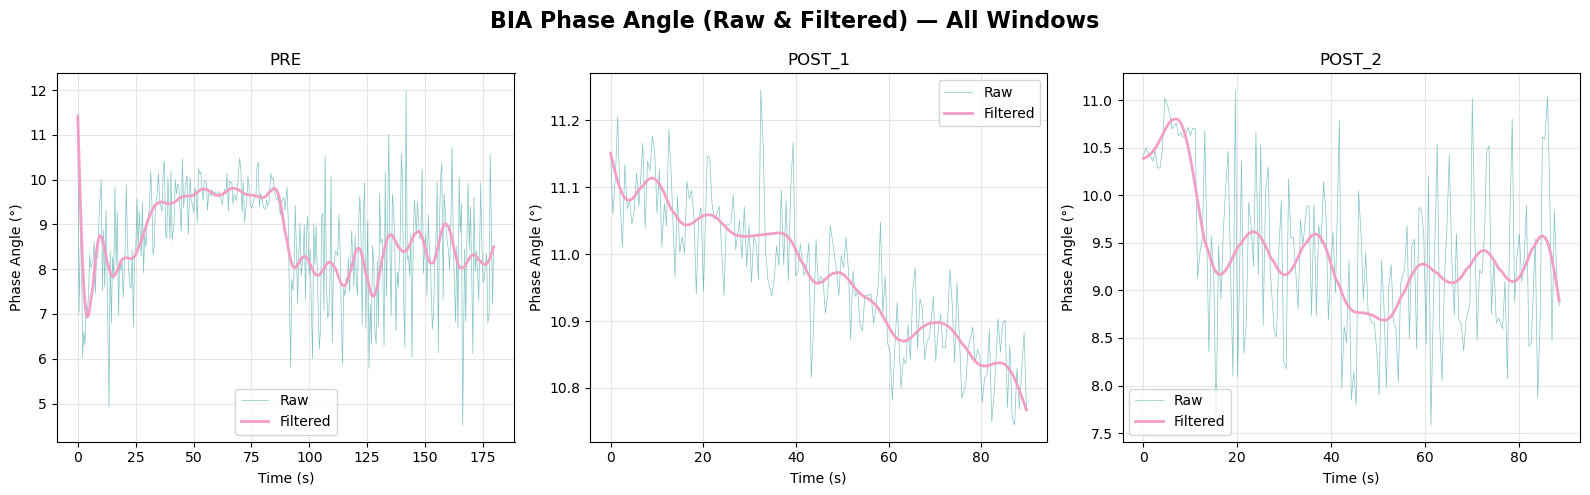

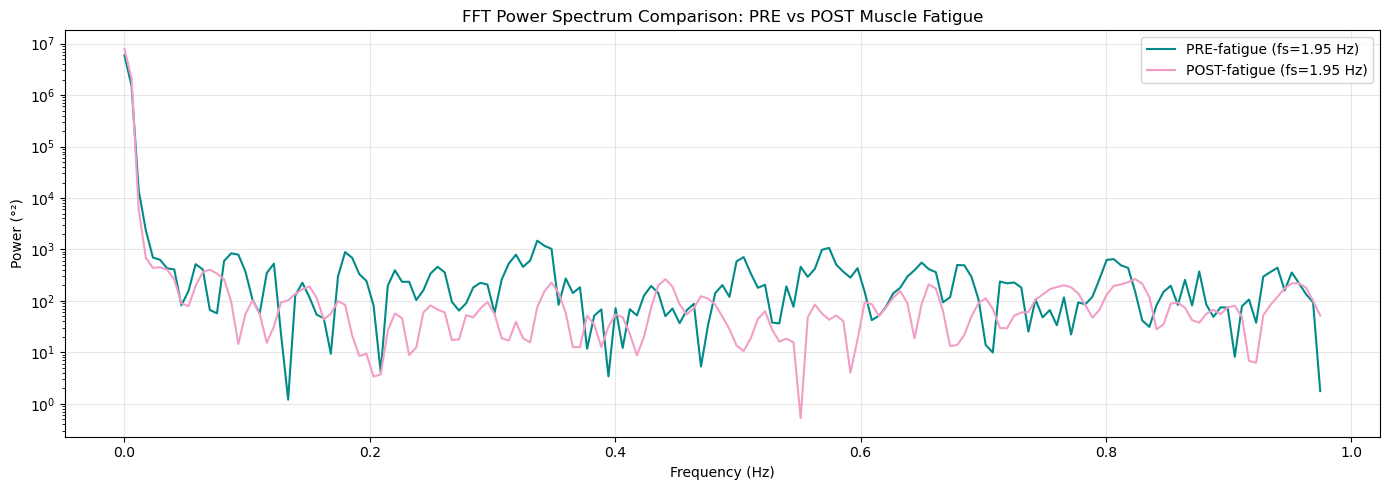

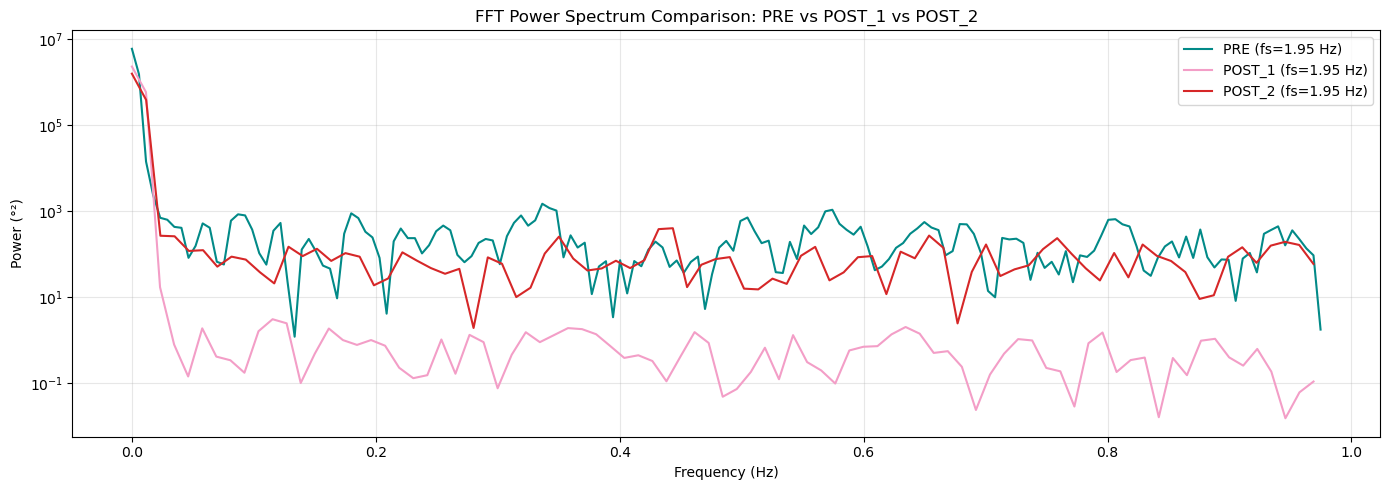

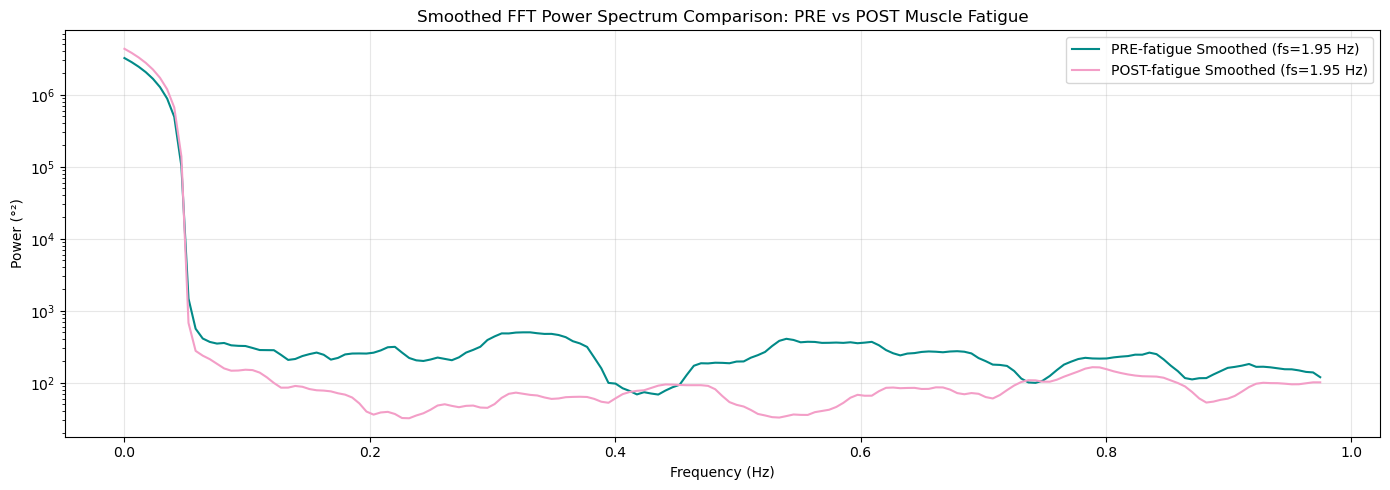

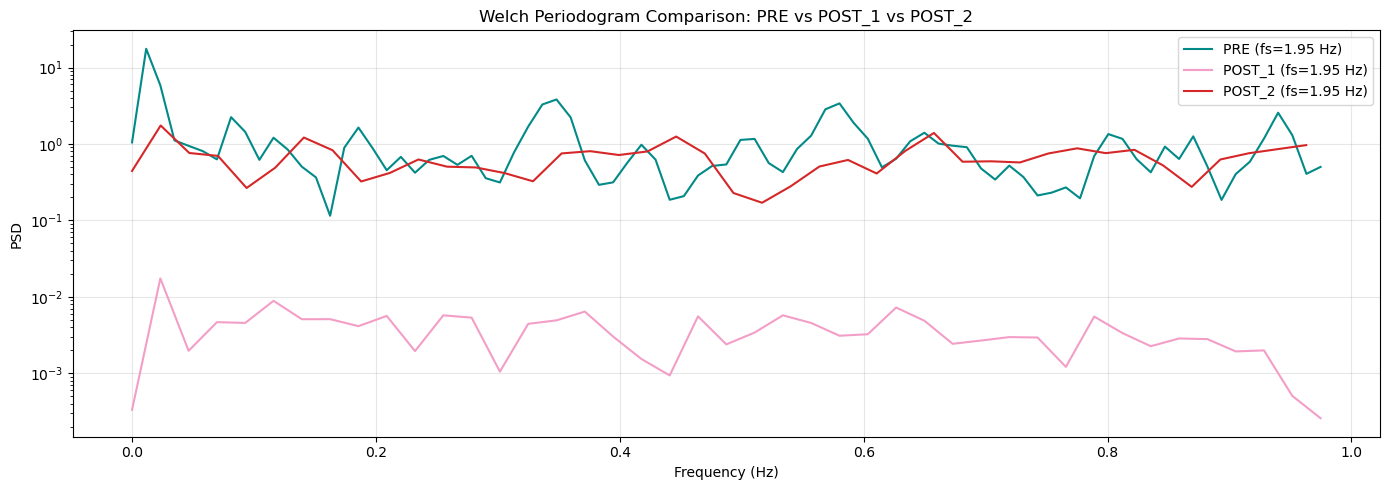

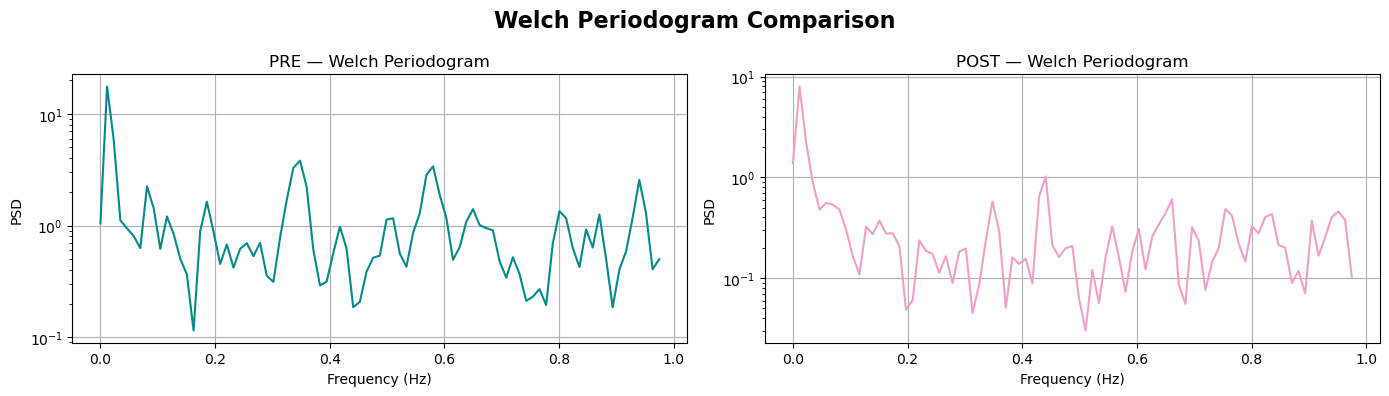

In [100]:
# =============================================================================
#  2. SPECTRAL ANALYSIS
# =============================================================================

# 1. BIA Phase Angle Signals (Raw and Filtered)

# Apply Butterworth lowpass filter
cutoff_freq = 0.1  # Hz
pha_pre_filtered = SpectralAnalysis.butter_lowpass_filter(pha_pre, cutoff=cutoff_freq, fs=fs_pre_est, order=5)
pha_post_filtered = SpectralAnalysis.butter_lowpass_filter(pha_post, cutoff=cutoff_freq, fs=fs_post_est, order=5)


# Exemple : plot seulement POST
SpectralAnalysis.plot_raw_and_filtered_panels(
    [{'time': t_post, 'raw': pha_post, 'filtered': pha_post_filtered}],
    titles=['BIA Phase Angle - POST Fatigue']
)

# Exemple : plot 3 fenêtres différentes
SpectralAnalysis.plot_raw_and_filtered_panels(
    [
        {'time': t_pre, 'raw': pha_pre, 'filtered': pha_pre_filtered},
        {'time': t_post_1, 'raw': pha_post_1, 'filtered': SpectralAnalysis.butter_lowpass_filter(pha_post_1, cutoff=0.1, fs=fs_post1_est)},
        {'time': t_post_2, 'raw': pha_post_2, 'filtered': SpectralAnalysis.butter_lowpass_filter(pha_post_2, cutoff=0.1, fs=fs_post2_est)},
    ],
    titles=['PRE', 'POST_1', 'POST_2'],
    suptitle='BIA Phase Angle (Raw & Filtered) — All Windows'
)


# 2. FFT Power Spectrum Comparison
freqs_fft_pre, power_fft_pre = SpectralAnalysis.compute_fft_power_spectrum(pha_pre, fs_pre_est)
freqs_fft_post, power_fft_post = SpectralAnalysis.compute_fft_power_spectrum(pha_post, fs_post_est)

SpectralAnalysis.plot_compare_power_spectra(
    [freqs_fft_pre, freqs_fft_post],
    [power_fft_pre, power_fft_post],
    [f'PRE-fatigue (fs={fs_pre_est:.2f} Hz)', f'POST-fatigue (fs={fs_post_est:.2f} Hz)'],
    title='FFT Power Spectrum Comparison: PRE vs POST Muscle Fatigue',
    ylabel='Power (°²)'
)

# FFT Power Spectrum pour PRE, POST_1, POST_2
freqs_fft_pre, power_fft_pre = SpectralAnalysis.compute_fft_power_spectrum(pha_pre, fs_pre_est)
freqs_fft_post1, power_fft_post1 = SpectralAnalysis.compute_fft_power_spectrum(pha_post_1, fs_post1_est)
freqs_fft_post2, power_fft_post2 = SpectralAnalysis.compute_fft_power_spectrum(pha_post_2, fs_post2_est)

SpectralAnalysis.plot_compare_power_spectra(
    [freqs_fft_pre, freqs_fft_post1, freqs_fft_post2],
    [power_fft_pre, power_fft_post1, power_fft_post2],
    [
        f'PRE (fs={fs_pre_est:.2f} Hz)',
        f'POST_1 (fs={fs_post1_est:.2f} Hz)',
        f'POST_2 (fs={fs_post2_est:.2f} Hz)'
    ],
    title='FFT Power Spectrum Comparison: PRE vs POST_1 vs POST_2',
    ylabel='Power (°²)'
)
# 3. Smoothed FFT Power Spectrum Comparison
from scipy.ndimage import uniform_filter1d
window_size = 15
power_fft_pre_smooth = uniform_filter1d(power_fft_pre, size=window_size, mode='nearest')
power_fft_post_smooth = uniform_filter1d(power_fft_post, size=window_size, mode='nearest')

SpectralAnalysis.plot_compare_power_spectra(
    [freqs_fft_pre, freqs_fft_post],
    [power_fft_pre_smooth, power_fft_post_smooth],
    [f'PRE-fatigue Smoothed (fs={fs_pre_est:.2f} Hz)', f'POST-fatigue Smoothed (fs={fs_post_est:.2f} Hz)'],
    title='Smoothed FFT Power Spectrum Comparison: PRE vs POST Muscle Fatigue',
    ylabel='Power (°²)'
)

# 4. Welch Periodogram (Individual)
freqs_pre, psd_pre = welch(pha_pre, fs=fs_pre_est, nperseg=min(256, len(pha_pre)//2))
freqs_post1, psd_post1 = welch(pha_post_1, fs=fs_post1_est, nperseg=min(256, len(pha_post_1)//2))
freqs_post2, psd_post2 = welch(pha_post_2, fs=fs_post2_est, nperseg=min(256, len(pha_post_2)//2))
freqs_post, psd_post = welch(pha_post, fs=fs_post_est, nperseg=min(256, len(pha_post)//2))

SpectralAnalysis.plot_compare_power_spectra(
    [freqs_pre, freqs_post1, freqs_post2],
    [psd_pre, psd_post1, psd_post2],
    [
        f'PRE (fs={fs_pre_est:.2f} Hz)',
        f'POST_1 (fs={fs_post1_est:.2f} Hz)',
        f'POST_2 (fs={fs_post2_est:.2f} Hz)'
    ],
    title='Welch Periodogram Comparison: PRE vs POST_1 vs POST_2',
    ylabel='PSD'
)




SpectralAnalysis.plot_welch_panels(
    [freqs_pre, freqs_post],
    [psd_pre, psd_post],
    titles=['PRE — Welch Periodogram', 'POST — Welch Periodogram'],
    suptitle='Welch Periodogram Comparison'
)

# Welch Periodogram pour PRE, POST_1, POST_2 


# 5. Dominant Frequency


idx_dom_pre = np.argmax(psd_pre)
f_dom_pre = freqs_pre[idx_dom_pre]
P_dom_pre = psd_pre[idx_dom_pre]

idx_dom_post = np.argmax(psd_post)
f_dom_post = freqs_post[idx_dom_post]
P_dom_post = psd_post[idx_dom_post]


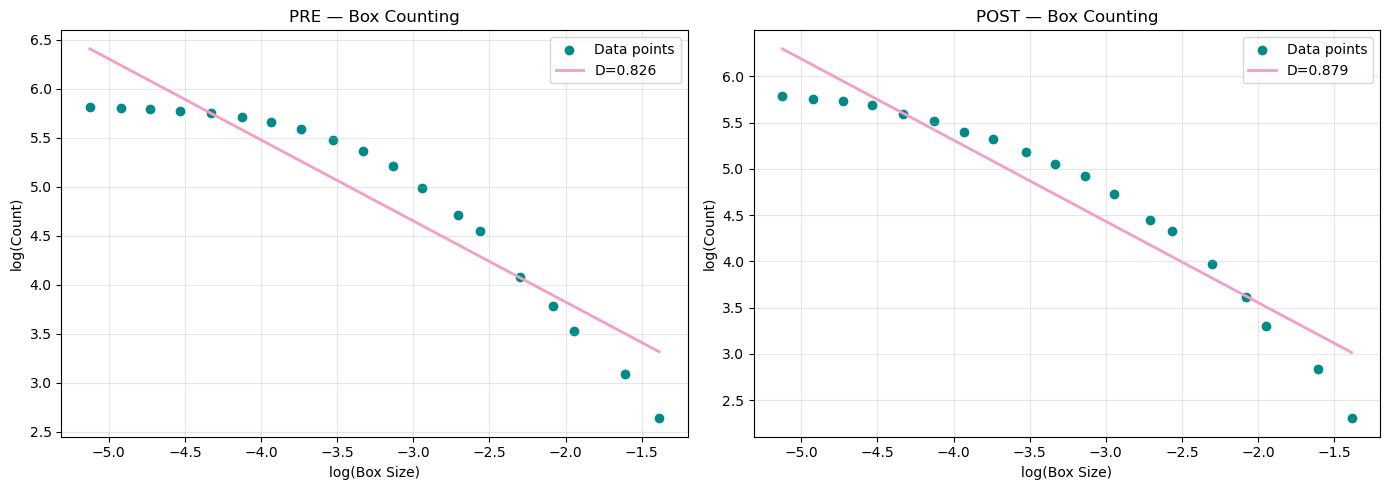

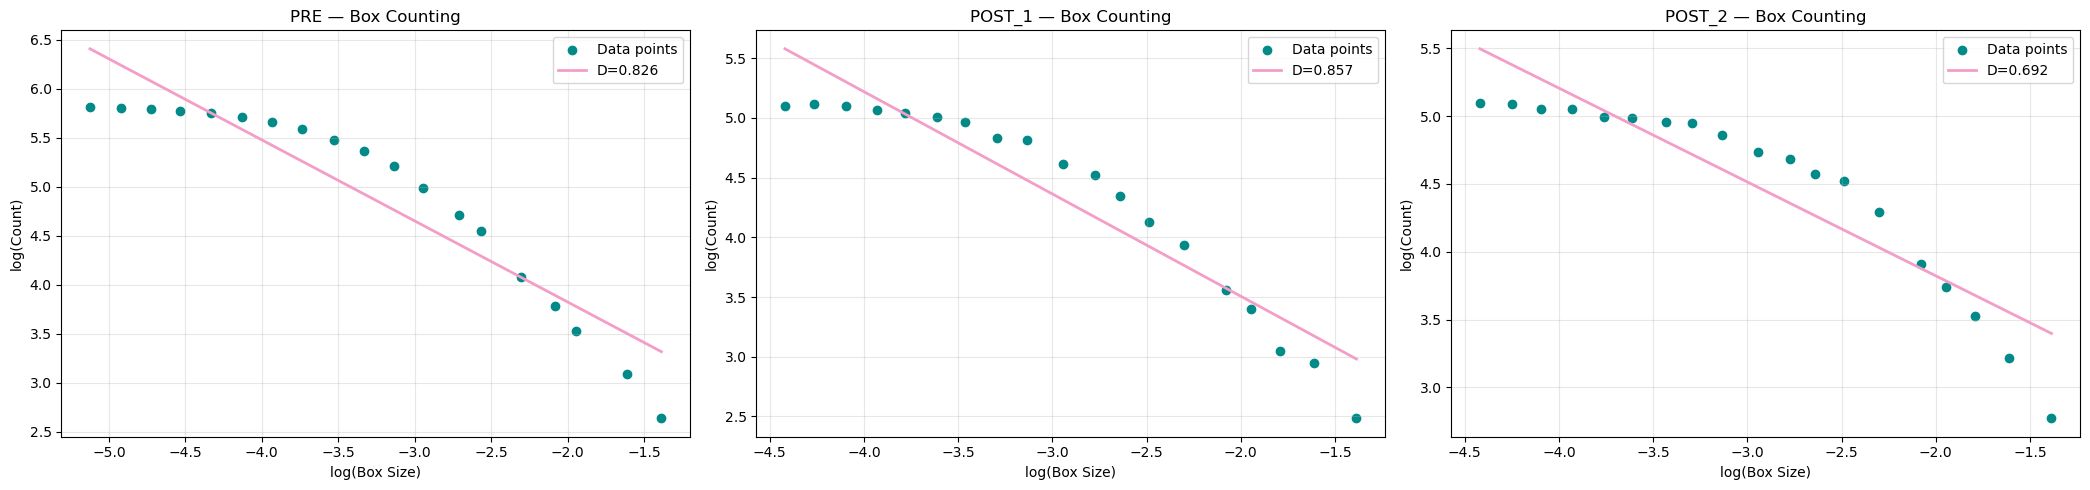

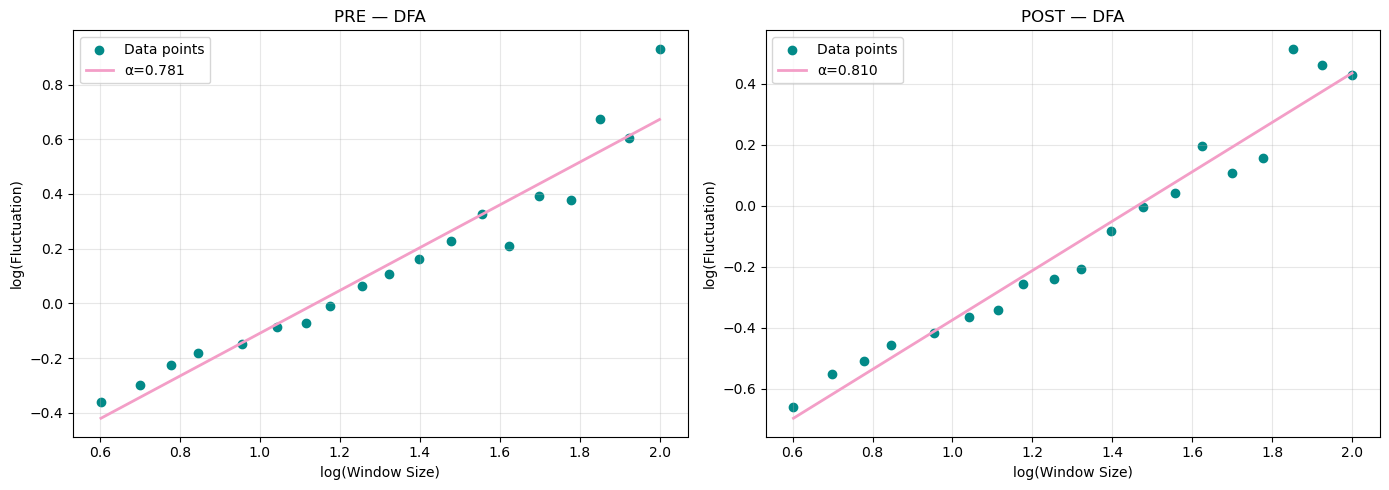

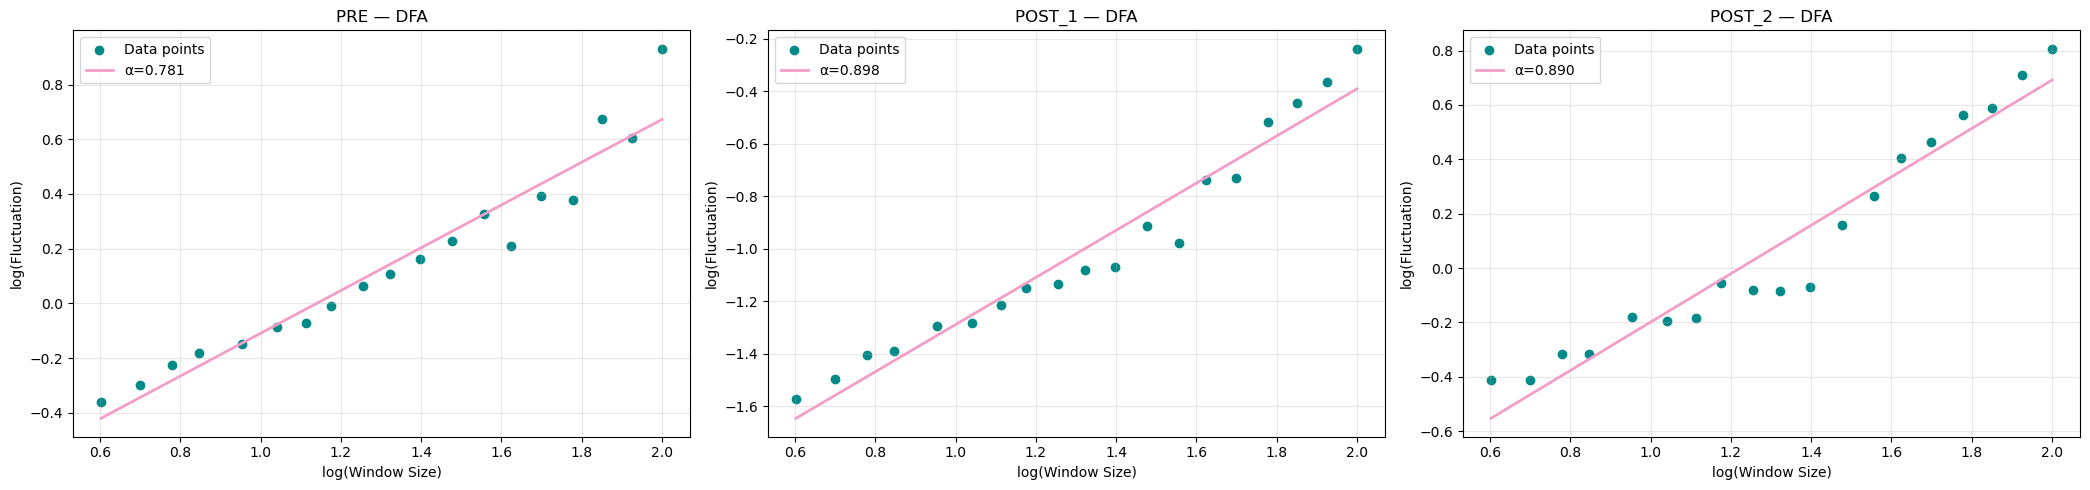

In [102]:
# =============================================================================
# 3. FRACTAL ANALYSIS
# =============================================================================

# Box Counting Dimension
dim_pre, box_sizes_pre, box_counts_pre = fractal_analysis.fractal_dimension_boxcount(pha_pre)
dim_post, box_sizes_post, box_counts_post = fractal_analysis.fractal_dimension_boxcount(pha_post)

fractal_analysis.plot_box_counting_panel([pha_pre, pha_post], labels=["PRE", "POST"])
fractal_analysis.plot_box_counting_panel(
    [pha_pre, pha_post_1, pha_post_2],
    labels=["PRE", "POST_1", "POST_2"]
)

# DFA Analysis
fractal_analysis.plot_dfa_panel([pha_pre, pha_post], labels=["PRE", "POST"])
fractal_analysis.plot_dfa_panel(
    [pha_pre, pha_post_1, pha_post_2],
    labels=["PRE", "POST_1", "POST_2"]
)

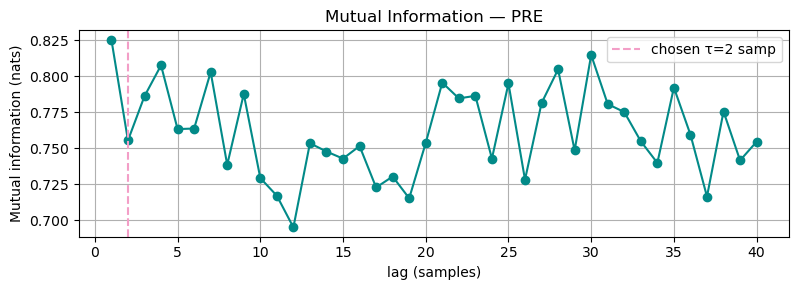

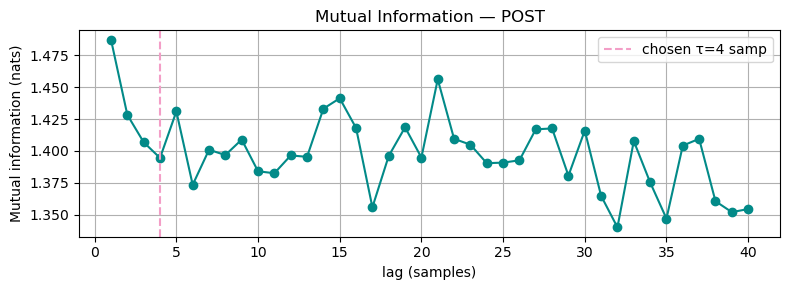

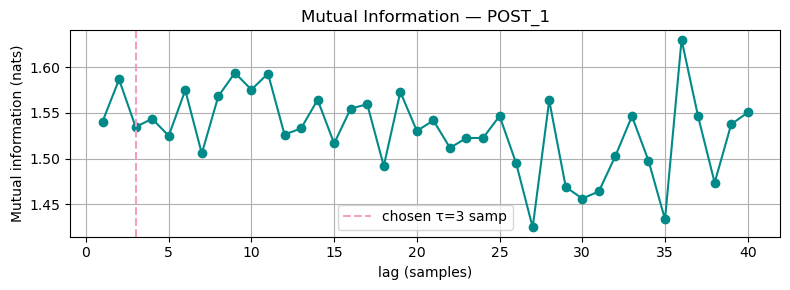

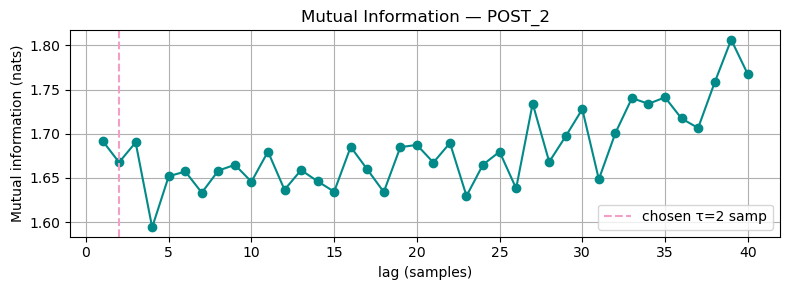

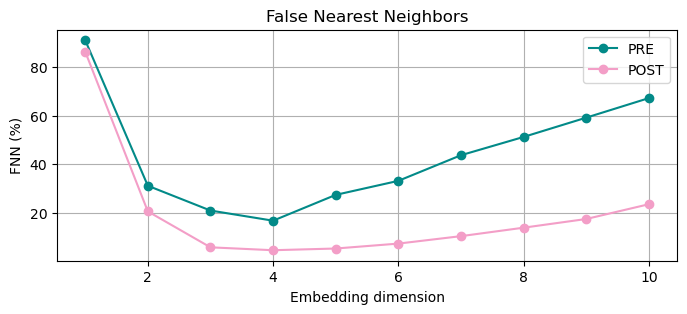

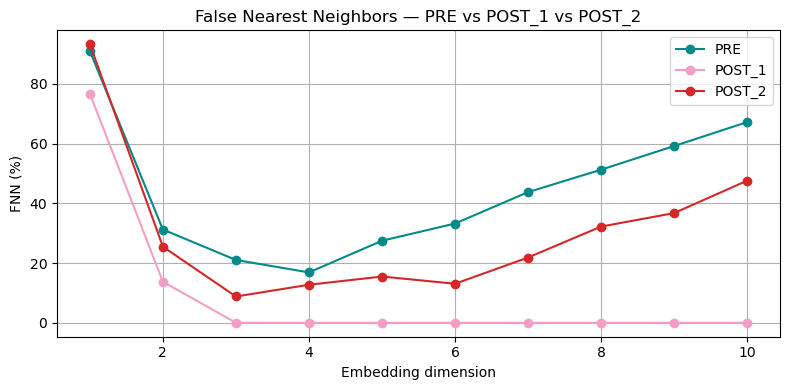

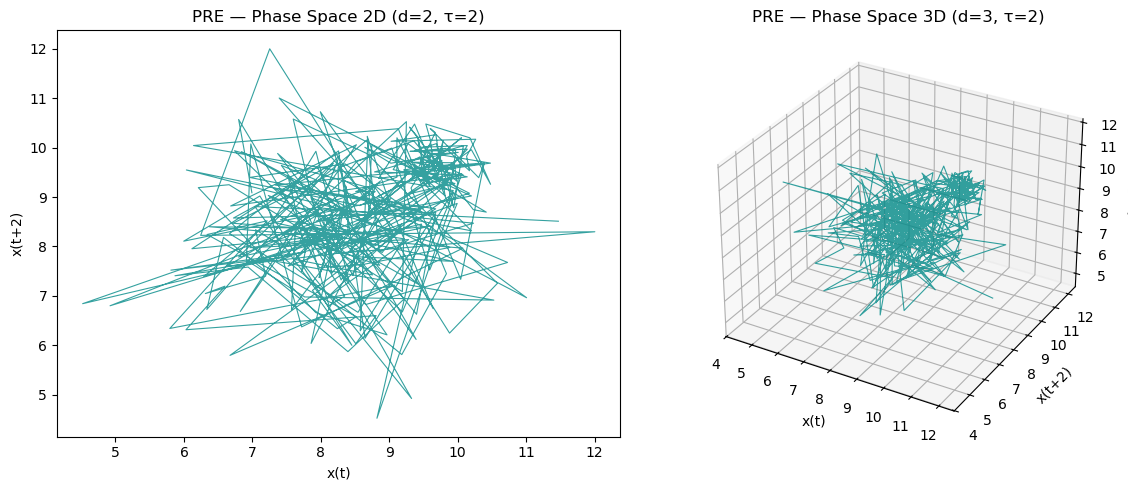

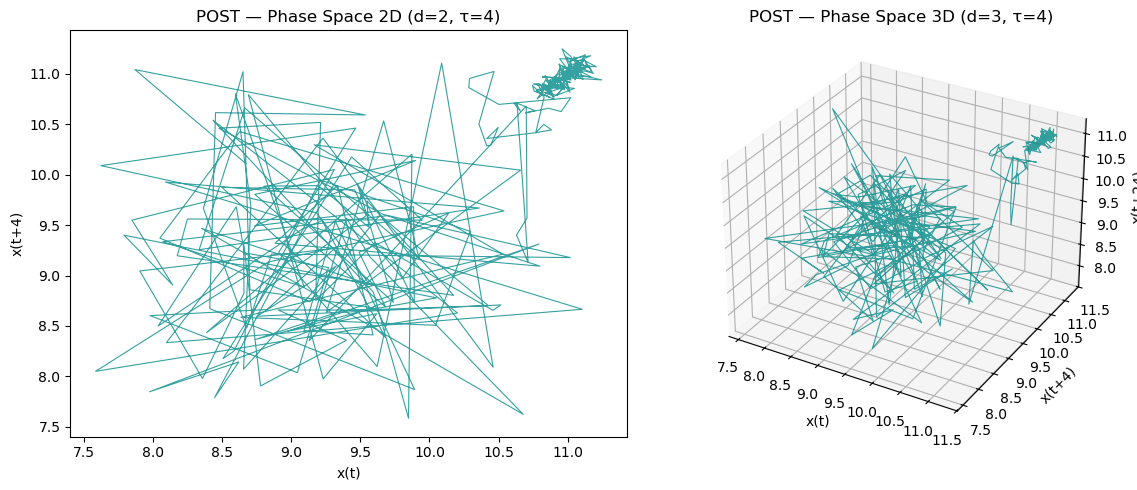

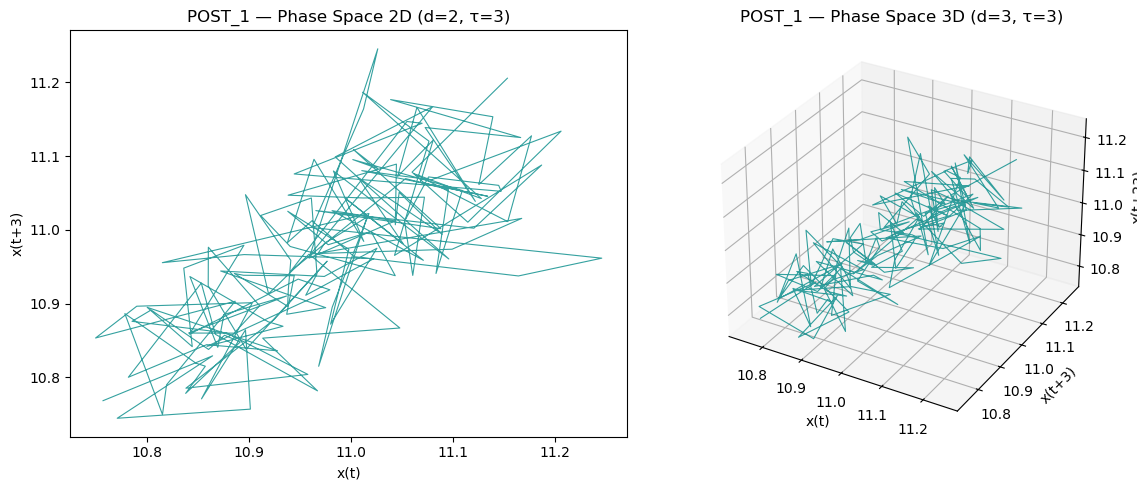

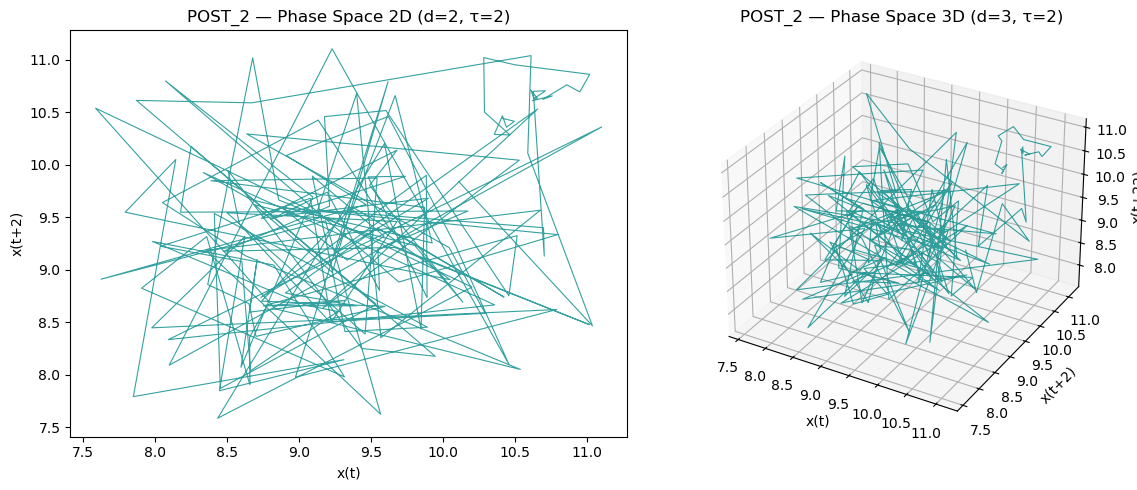

0.8500950650082648
0.34103483132459605
2.890371757896165
0.7801585575495751

SURROGATE DATA ANALYSIS - PSD PRESERVATION CHECK

Generating surrogate for PRE...
Checking PSD preservation for PRE:


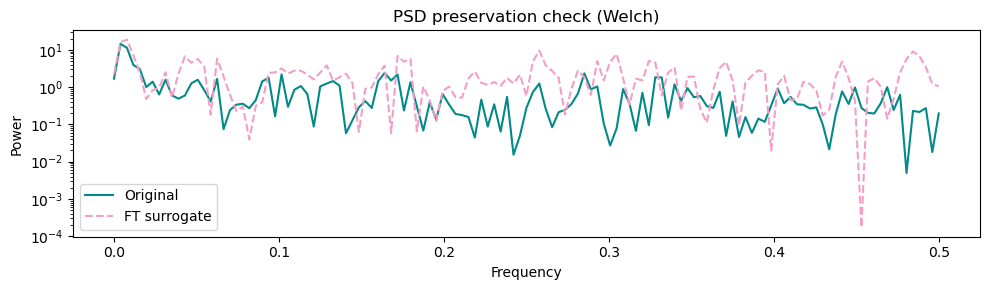

FFT amplitude preservation test
  allclose: True
  rel_RMSE: 4.648e-16
  max_rel : 1.808e-15

PRE - FFT Amplitude Preservation:
  Test passed: True
  Relative RMSE: 4.648e-16
  Max relative error: 1.808e-15

Generating surrogate for POST...
Checking PSD preservation for POST:


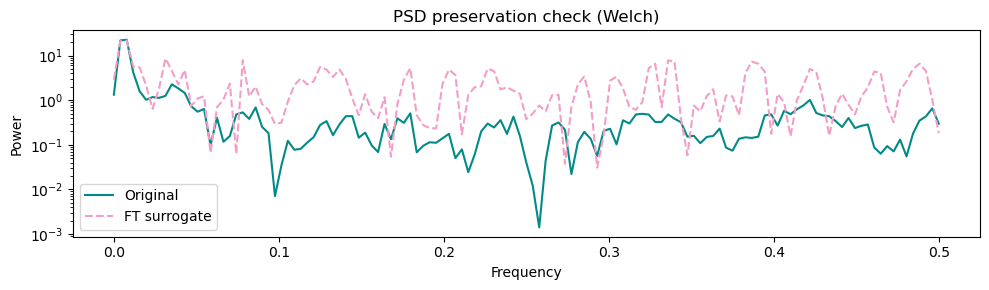

FFT amplitude preservation test
  allclose: True
  rel_RMSE: 1.358e-04
  max_rel : 1.765e-03

POST - FFT Amplitude Preservation:
  Test passed: True
  Relative RMSE: 1.358e-04
  Max relative error: 1.765e-03

Generating surrogate for POST_1...
Checking PSD preservation for POST_1:


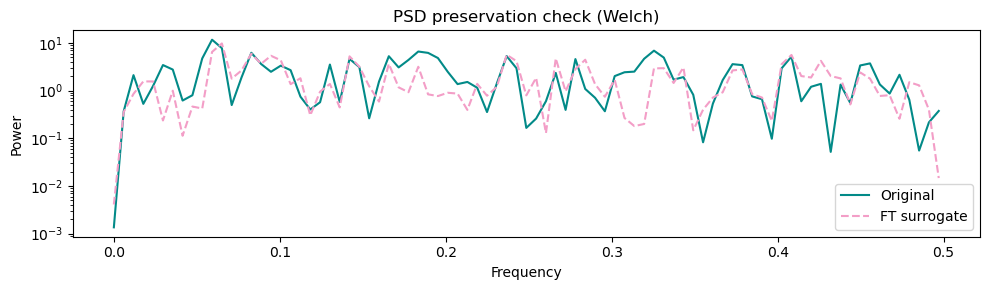

FFT amplitude preservation test
  allclose: True
  rel_RMSE: 2.407e-05
  max_rel : 2.219e-04

POST_1 - FFT Amplitude Preservation:
  Test passed: True
  Relative RMSE: 2.407e-05
  Max relative error: 2.219e-04

Generating surrogate for POST_2...
Checking PSD preservation for POST_2:


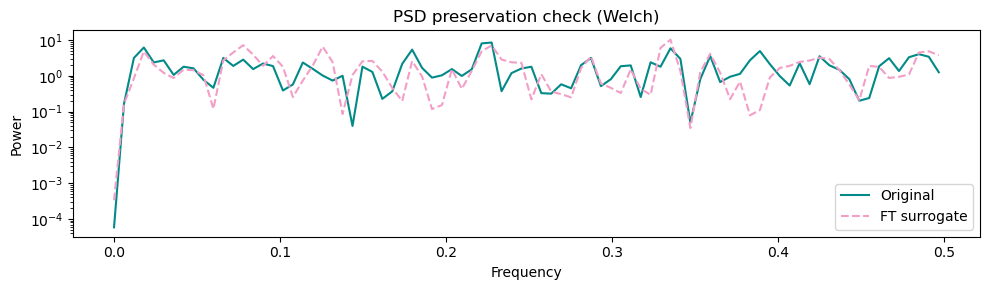

FFT amplitude preservation test
  allclose: True
  rel_RMSE: 6.017e-04
  max_rel : 5.514e-03

POST_2 - FFT Amplitude Preservation:
  Test passed: True
  Relative RMSE: 6.017e-04
  Max relative error: 5.514e-03

→ Surrogates preserve power spectrum (linear properties)
→ Phase randomization destroys nonlinear structure


In [110]:
# ...existing code...

# =============================================================================
# 4. NON-LINEAR ANALYSIS
# =============================================================================
# Mutual Information
MAX_LAG = 40
lags_pre, mi_pre = NonLinearAnalysis.compute_mi_lags(pha_pre, max_lag=MAX_LAG, bins=32)
tau_pre_mi = NonLinearAnalysis.first_local_minimum(lags_pre, mi_pre) if lags_pre.size else None

lags_post, mi_post = NonLinearAnalysis.compute_mi_lags(pha_post, max_lag=MAX_LAG, bins=32)
tau_post_mi = NonLinearAnalysis.first_local_minimum(lags_post, mi_post) if lags_post.size else None

lags_post1, mi_post1 = NonLinearAnalysis.compute_mi_lags(pha_post_1, max_lag=MAX_LAG, bins=32)
tau_post1_mi = NonLinearAnalysis.first_local_minimum(lags_post1, mi_post1) if lags_post1.size else None

lags_post2, mi_post2 = NonLinearAnalysis.compute_mi_lags(pha_post_2, max_lag=MAX_LAG, bins=32)
tau_post2_mi = NonLinearAnalysis.first_local_minimum(lags_post2, mi_post2) if lags_post2.size else None

# Plot MI: 1 plot per window
NonLinearAnalysis.plot_mi(lags_pre, mi_pre, chosen_tau=tau_pre_mi, title="Mutual Information — PRE")
NonLinearAnalysis.plot_mi(lags_post, mi_post, chosen_tau=tau_post_mi, title="Mutual Information — POST")
NonLinearAnalysis.plot_mi(lags_post1, mi_post1, chosen_tau=tau_post1_mi, title="Mutual Information — POST_1")
NonLinearAnalysis.plot_mi(lags_post2, mi_post2, chosen_tau=tau_post2_mi, title="Mutual Information — POST_2")

# False Nearest Neighbors
tau_use_pre = tau_pre_mi if tau_pre_mi else 3
tau_use_post = tau_post_mi if tau_post_mi else 4
tau_use_post1 = tau_post1_mi if tau_post1_mi else 4
tau_use_post2 = tau_post2_mi if tau_post2_mi else 4

fnn_pre = NonLinearAnalysis.false_nearest_neighbors(pha_pre, max_dim=10, tau=tau_use_pre)
optimal_d_pre = np.argmin(fnn_pre) + 1

fnn_post = NonLinearAnalysis.false_nearest_neighbors(pha_post, max_dim=10, tau=tau_use_post)
optimal_d_post = np.argmin(fnn_post) + 1

fnn_post1 = NonLinearAnalysis.false_nearest_neighbors(pha_post_1, max_dim=10, tau=tau_use_post1)
optimal_d_post1 = np.argmin(fnn_post1) + 1

fnn_post2 = NonLinearAnalysis.false_nearest_neighbors(pha_post_2, max_dim=10, tau=tau_use_post2)
optimal_d_post2 = np.argmin(fnn_post2) + 1

# Plot FNN: PRE vs POST
NonLinearAnalysis.plot_fnn(fnn_pre, fnn_post, label_pre="PRE", label_post="POST")
# Plot FNN: PRE vs POST_1 vs POST_2 
NonLinearAnalysis.plot_fnn_multi(
    [fnn_pre, fnn_post1, fnn_post2],
    labels=["PRE", "POST_1", "POST_2"],
    title="False Nearest Neighbors — PRE vs POST_1 vs POST_2"
)

# Phase Space Reconstruction: 1 plot per window 2D 
NonLinearAnalysis.plot_phase_space_2d_3d(pha_pre, tau_use_pre, d=3, label="PRE")
NonLinearAnalysis.plot_phase_space_2d_3d(pha_post, tau_use_post, d=3, label="POST")
NonLinearAnalysis.plot_phase_space_2d_3d(pha_post_1, tau_use_post1, d=3, label="POST_1")
NonLinearAnalysis.plot_phase_space_2d_3d(pha_post_2, tau_use_post2, d=3, label="POST_2")



# Detrending & Standardization
pha_pre_detrend = NonLinearAnalysis.detrend_polynomial(pha_pre, order=3)
pha_post_detrend = NonLinearAnalysis.detrend_polynomial(pha_post, order=3)
pha_post1_detrend = NonLinearAnalysis.detrend_polynomial(pha_post_1, order=3)
pha_post2_detrend = NonLinearAnalysis.detrend_polynomial(pha_post_2, order=3)

pha_pre_std = (pha_pre_detrend - np.mean(pha_pre_detrend)) / np.std(pha_pre_detrend)
pha_post_std = (pha_post_detrend - np.mean(pha_post_detrend)) / np.std(pha_post_detrend)
pha_post1_std = (pha_post1_detrend - np.mean(pha_post1_detrend)) / np.std(pha_post1_detrend)
pha_post2_std = (pha_post2_detrend - np.mean(pha_post2_detrend)) / np.std(pha_post2_detrend)

# Sample Entropy
m, r = 3, 0.20
sampen_pre = NonLinearAnalysis.sample_entropy(pha_pre_std, m=m, r=r)
sampen_post = NonLinearAnalysis.sample_entropy(pha_post_std, m=m, r=r)
sampen_post1 = NonLinearAnalysis.sample_entropy(pha_post1_std, m=m, r=r)
sampen_post2 = NonLinearAnalysis.sample_entropy(pha_post2_std, m=m, r=r)
print(sampen_pre)
print(sampen_post)
print(sampen_post1)
print(sampen_post2)
# Surrogate Data Analysis - PSD Preservation Check
print("\n" + "="*80)
print("SURROGATE DATA ANALYSIS - PSD PRESERVATION CHECK")
print("="*80)

# Generate phase-randomized surrogates for PRE/POST/POST_1/POST_2
for label, arr in zip(
    ["PRE", "POST", "POST_1", "POST_2"],
    [pha_pre_std, pha_post_std, pha_post1_std, pha_post2_std]
):
    print(f"\nGenerating surrogate for {label}...")
    surr = NonLinearAnalysis.phase_randomized_surrogate(arr, random_state=42)
    print(f"Checking PSD preservation for {label}:")
    NonLinearAnalysis.check_psd(arr, surr, nperseg=min(256, len(arr)))
    ok, rmse, max_rel = NonLinearAnalysis.test_fft_amplitude_preservation(arr, surr)
    print(f"\n{label} - FFT Amplitude Preservation:")
    print(f"  Test passed: {ok}")
    print(f"  Relative RMSE: {rmse:.3e}")
    print(f"  Max relative error: {max_rel:.3e}")

print("\n" + "="*80)
print("→ Surrogates preserve power spectrum (linear properties)")
print("→ Phase randomization destroys nonlinear structure")
print("="*80)